<a href="https://colab.research.google.com/github/RohanHanda/Pneumonia-Detection-from-Xray/blob/main/PneumoniaDetectionFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet201

In [5]:
IMG_SIZE = (300, 300)
BATCH_SIZE = 16


**DataSet and Image Augmentation**

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
)

train_gen = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Pneumonia_Detection/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)


Found 4692 images belonging to 3 classes.


In [7]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_directory(
    "/content/drive/MyDrive/Pneumonia_Detection/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 524 images belonging to 3 classes.


**Class Imbalance**

In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.6877748460861918), 1: np.float64(1.295774647887324), 2: np.float64(1.2914946325350949)}


**Importing Pretrained Model: Dense Net 201**

In [11]:
base_model = DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3) # Corrected: use individual elements of IMG_SIZE
)
base_model.trainable = False

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


**Model Architecture**

In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(3, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=outputs)

In [14]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "DenseNetBest.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-7, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

callbacks = [checkpoint, reduce_lr, early_stop]

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy",tf.keras.metrics.AUC(name="auc")]
)


In [16]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


**Feature Extraction**

In [17]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6106 - auc: 0.7961 - loss: 0.8438
Epoch 1: val_accuracy improved from -inf to 0.79580, saving model to scratch_best.keras
294/294 ━━━━━━━━━━━━━━━━━━━━ 2760s 9s/step - accuracy: 0.6108 - auc: 0.7963 - loss: 0.8435 - val_accuracy: 0.7958 - val_auc: 0.9275 - val_loss: 0.5267 - learning_rate: 1.0000e-04
Epoch 2/15
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.7125 - auc: 0.8840 - loss: 0.6193
Epoch 2: val_accuracy improved from 0.79580 to 0.81107, saving model to scratch_best.keras
294/294 ━━━━━━━━━━━━━━━━━━━━ 161s 549ms/step - accuracy: 0.7126 - auc: 0.8840 - loss: 0.6192 - val_accuracy: 0.8111 - val_auc: 0.9429 - val_loss: 0.4520 - learning_rate: 1.0000e-04
Epoch 3/15
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.7292 - auc: 0.8999 - loss: 0.5753
Epoch 3: val_accuracy did not improve from 0.81107
294/294 ━━━━━━━━━━━━━━━━━━━━ 165s 559ms/step - accuracy: 0.7293 - auc: 0.8999 - loss: 0.5752 - val_accuracy

**Fine Tunning**

In [19]:
base_model.trainable = True

for layer in base_model.layers[:-60]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.7656 - auc: 0.9232 - loss: 0.4765
Epoch 1: val_accuracy did not improve from 0.84351
294/294 ━━━━━━━━━━━━━━━━━━━━ 328s 895ms/step - accuracy: 0.7656 - auc: 0.9232 - loss: 0.4764 - val_accuracy: 0.8435 - val_auc: 0.9535 - val_loss: 0.4079 - learning_rate: 1.0000e-05
Epoch 2/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.7918 - auc: 0.9319 - loss: 0.4667
Epoch 2: val_accuracy did not improve from 0.84351
294/294 ━━━━━━━━━━━━━━━━━━━━ 165s 560ms/step - accuracy: 0.7918 - auc: 0.9319 - loss: 0.4667 - val_accuracy: 0.8416 - val_auc: 0.9508 - val_loss: 0.4255 - learning_rate: 1.0000e-05
Epoch 3/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.7889 - auc: 0.9343 - loss: 0.4421
Epoch 3: val_accuracy did not improve from 0.84351
294/294 ━━━━━━━━━━━━━━━━━━━━ 160s 544ms/step - accuracy: 0.7889 - auc: 0.9343 - loss: 0.4421 - val_accuracy: 0.8416 - val_auc: 0.9489 - val_loss: 0.4363 - learning_rate: 1.0000e-0

**Graphs**

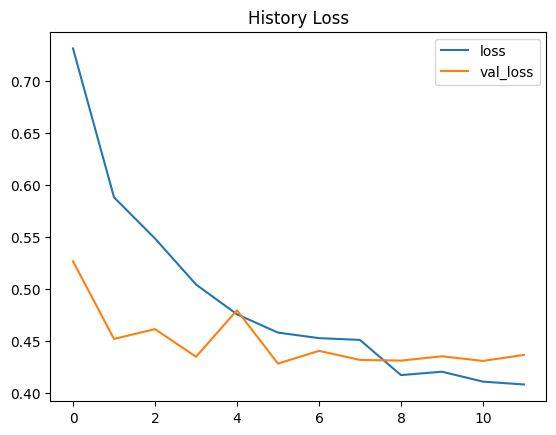

In [30]:
import matplotlib.pyplot as plt
plt.title("History Loss")
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()

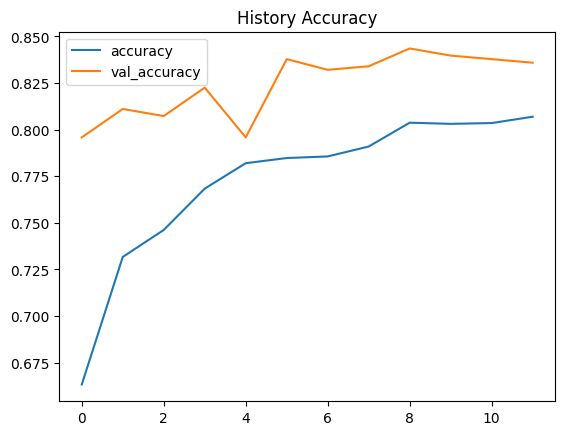

In [34]:
import matplotlib.pyplot as plt
plt.title("History Accuracy")
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()

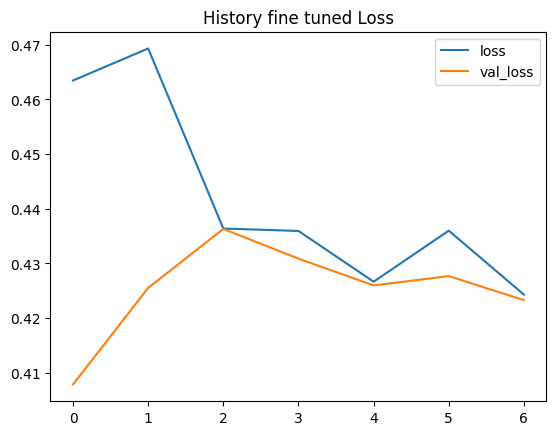

In [35]:
import matplotlib.pyplot as plt
plt.title("History fine tuned Loss")
plt.plot(history_fine.history['loss'], label = 'loss')
plt.plot(history_fine.history['val_loss'], label = 'val_loss')
plt.legend()

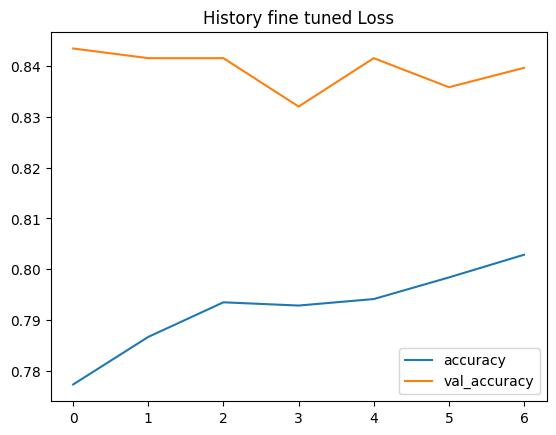

In [36]:
import matplotlib.pyplot as plt
plt.title("History fine tuned Loss")
plt.plot(history_fine.history['accuracy'], label = 'accuracy')
plt.plot(history_fine.history['val_accuracy'], label = 'val_accuracy')
plt.legend()

**Testing the model**

In [24]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# ------------------------------
# SETTINGS
# ------------------------------
IMG_SIZE = 300      # use same size you trained on
classes = ["BACTERIAL", "NORMAL", "VIRAL"]
test_folder = "/content/drive/MyDrive/Pneumonia_Detection/test"   # <--- change this

# Load your trained model
# (If your model is already in memory, skip this)
# model = load_model("/kaggle/working/my_model.h5")

# ------------------------------
# FUNCTION TO PREDICT A SINGLE IMAGE
# ------------------------------
def predict_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)[0]
    cls_id = np.argmax(preds)
    prob = preds[cls_id]

    return classes[cls_id], float(prob)

# ------------------------------
# LOOP THROUGH ENTIRE FOLDER
# ------------------------------
results = []

for filename in os.listdir(test_folder):
    if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
        img_path = os.path.join(test_folder, filename)

        pred_label, confidence = predict_image(img_path)

        results.append((filename, pred_label, confidence))
        print(f"{filename}:  {pred_label}  ({confidence*100:.2f}%)")

# ------------------------------
# OPTIONAL: Save results as CSV
# ------------------------------
import pandas as pd

df = pd.DataFrame(results, columns=["filename", "prediction", "confidence"])
df.to_csv("folder_predictions.csv", index=False)

print("\nSaved results → folder_predictions.csv")


1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step
person628_virus_1206.jpeg:  VIRAL  (84.81%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
IM-_normal_0029-0001.jpeg:  NORMAL  (96.85%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
person629_bacteria_2508.jpeg:  BACTERIAL  (96.48%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
person626_bacteria_2502.jpeg:  BACTERIAL  (71.37%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
person630_bacteria_2514.jpeg:  BACTERIAL  (94.32%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
IM-0017_normal_-0001.jpeg:  NORMAL  (98.60%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
person630_bacteria_2515.jpeg:  BACTERIAL  (96.07%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
person632_virus_1211.jpeg:  VIRAL  (96.67%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
IM-0016_normal_0001.jpeg:  NORMAL  (93.39%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
person639_virus_1220.jpeg:  BACTERIAL  (90.68%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
person637_bacteria_2528.jpeg:  BACTERIAL  (96.65%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
person636_virus_121

**Metrics**

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step


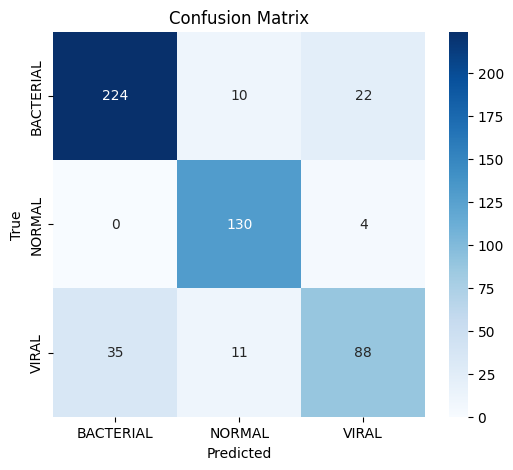

              precision    recall  f1-score   support

   BACTERIAL       0.86      0.88      0.87       256
      NORMAL       0.86      0.97      0.91       134
       VIRAL       0.77      0.66      0.71       134

    accuracy                           0.84       524
   macro avg       0.83      0.83      0.83       524
weighted avg       0.84      0.84      0.84       524

AUC Score: 0.9375493326636052


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Get true & predicted classes
val_gen.reset()
y_true = val_gen.classes
y_probs = model.predict(val_gen)
y_pred = np.argmax(y_probs, axis=1)

classes = ["BACTERIAL", "NORMAL", "VIRAL"]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)
plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

# Multi-class AUC
auc = roc_auc_score(tf.keras.utils.to_categorical(y_true, 3), y_probs, multi_class="ovr")
print("AUC Score:", auc)


In [25]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred, average="macro")
print("Macro F1:", f1)


Macro F1: 0.8306203445768613


In [27]:
from sklearn.metrics import roc_auc_score
import tensorflow as tf

y_true = val_gen.classes
y_probs = model.predict(val_gen)

y_true_oh = tf.keras.utils.to_categorical(y_true, num_classes=3)

auc = roc_auc_score(y_true_oh, y_probs, multi_class="ovr")
print("Correct AUC:", auc)

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step
Correct AUC: 0.9375493326636052


In [5]:
import gradio as gr
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image

# ===== CONFIG =====
IMG_SIZE = 300
CLASSES = ["BACTERIAL", "NORMAL", "VIRAL"]
MODEL_PATH = "DenseNet201Final.keras"      # adjust path if needed
LAST_CONV_LAYER = "conv5_block32_concat"       # must exist in model summary

# ===== Load Model =====
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# ===== Grad-CAM Function =====
def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-10

    return heatmap, int(class_idx)

# ===== Prediction Function =====
def predict_xray(image):
    if image is None:
        return None, "No image uploaded"

    # Convert PIL → NumPy
    img = np.array(image.convert("RGB"))
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_norm = img_resized / 255.0
    input_img = np.expand_dims(img_norm, axis=0)

    # Prediction
    preds = model.predict(input_img)
    class_idx = np.argmax(preds)
    confidence = np.max(preds)

    label = f"{CLASSES[class_idx]} ({confidence:.2%})"

    # Grad-CAM
    heatmap, _ = grad_cam(model, input_img, LAST_CONV_LAYER)
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    colored_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed = cv2.addWeighted(
        colored_heatmap, 0.5,
        np.uint8(img_resized), 0.5,
        0
    )

    return Image.fromarray(superimposed), label

# ===== Gradio UI =====
demo = gr.Interface(
    fn=predict_xray,
    inputs=gr.Image(type="pil", label="Upload Chest X-ray"),
    outputs=[
        gr.Image(label="Grad-CAM Heatmap"),
        gr.Textbox(label="Prediction")
    ],
    title="🫁 Chest X-ray Pneumonia Classifier",
    description="DenseNet201-based model with Grad-CAM explainability",
    allow_flagging="never"
)

if __name__ == "__main__":
    demo.launch()


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://99248285d1a9ef2068.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
